# Model Fit in Linear Regression - Lab

## Introduction
In this lab, you'll learn how to evaluate your model results and you'll learn how to select the appropriate features using stepwise selection.

## Objectives
You will be able to:
* Use stepwise selection methods to determine the most important features for a model
* Use recursive feature elimination to determine the most important features for a model

## The Boston Housing Data once more

We pre-processed the Boston Housing data the same way we did before:

- We dropped `'ZN'` and `'NOX'` completely
- We categorized `'RAD'` in 3 bins and `'TAX'` in 4 bins
- We transformed `'RAD'` and `'TAX'` to dummy variables and dropped the first variable
- We used min-max-scaling on `'B'`, `'CRIM'`, and `'DIS'` (and logtransformed all of them first, except `'B'`)
- We used standardization on `'AGE'`, `'INDUS'`, `'LSTAT'`, and `'PTRATIO'` (and logtransformed all of them first, except for `'AGE'`) 

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
boston = load_boston()

boston_features = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_features = boston_features.drop(['NOX', 'ZN'],axis=1)

# First, create bins for based on the values observed. 3 values will result in 2 bins
bins = [0,6,  24]
bins_rad = pd.cut(boston_features['RAD'], bins)
bins_rad = bins_rad.cat.as_unordered()

# First, create bins for based on the values observed. 4 values will result in 3 bins
bins = [0, 270, 360, 712]
bins_tax = pd.cut(boston_features['TAX'], bins)
bins_tax = bins_tax.cat.as_unordered()

tax_dummy = pd.get_dummies(bins_tax, prefix='TAX', drop_first=True)
rad_dummy = pd.get_dummies(bins_rad, prefix='RAD', drop_first=True)
boston_features = boston_features.drop(['RAD', 'TAX'], axis=1)
boston_features = pd.concat([boston_features, rad_dummy, tax_dummy], axis=1)

age = boston_features['AGE']
b = boston_features['B']
logcrim = np.log(boston_features['CRIM'])
logdis = np.log(boston_features['DIS'])
logindus = np.log(boston_features['INDUS'])
loglstat = np.log(boston_features['LSTAT'])
logptratio = np.log(boston_features['PTRATIO'])

# Min-Max scaling
boston_features['B'] = (b-min(b))/(max(b)-min(b))
boston_features['CRIM'] = (logcrim-min(logcrim))/(max(logcrim)-min(logcrim))
boston_features['DIS'] = (logdis-min(logdis))/(max(logdis)-min(logdis))

# Standardization
boston_features['AGE'] = (age-np.mean(age))/np.sqrt(np.var(age))
boston_features['INDUS'] = (logindus-np.mean(logindus))/np.sqrt(np.var(logindus))
boston_features['LSTAT'] = (loglstat-np.mean(loglstat))/np.sqrt(np.var(loglstat))
boston_features['PTRATIO'] = (logptratio-np.mean(logptratio))/(np.sqrt(np.var(logptratio)))

In [2]:
boston_features

,CRIM,INDUS,CHAS,RM,AGE,DIS,PTRATIO,B,LSTAT,"RAD_(6, 24]","TAX_(270, 360]","TAX_(360, 712]"
0,0.000000,-1.704344,0.0,6.575,-0.120013,0.542096,-1.443977,1.000000,-1.275260,0,1,0
1,0.153211,-0.263239,0.0,6.421,0.367166,0.623954,-0.230278,1.000000,-0.263711,0,0,0
2,0.153134,-0.263239,0.0,7.185,-0.265812,0.623954,-0.230278,0.989737,-1.627858,0,0,0
3,0.171005,-1.778965,0.0,6.998,-0.809889,0.707895,0.165279,0.994276,-2.153192,0,0,0
4,0.250315,-1.778965,0.0,7.147,-0.511180,0.707895,0.165279,1.000000,-1.162114,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.240099,0.410792,0.0,6.593,0.018673,0.331081,1.095518,0.987619,-0.169811,0,1,0
502,0.206118,0.410792,0.0,6.120,0.288933,0.297277,1.095518,1.000000,-0.274682,0,1,0
503,0.236926,0.410792,0.0,6.976,0.797449,0.274575,1.095518,1.000000,-1.067939,0,1,0
504,0.298671,0.410792,0.0,6.794,0.736996,0.315551,1.095518,0.991301,-0.836660,0,1,0


## Perform stepwise selection

The function for stepwise selection is copied below. Use this function provided on your preprocessed Boston Housing data.

In [19]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [20]:
# Your code here

# dependent variable
# boston.keys()
# boston.target
y = pd.DataFrame(boston.target, columns = ['price'])
y

results= stepwise_selection(boston_features, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True)
#     """ Perform a forward-backward feature selection 
#     based on p-value from statsmodels.api.OLS
#     Arguments:
#         X - pandas.DataFrame with candidate features
#         y - list-like with the target
#         initial_list - list of features to start with (column names of X)
#         threshold_in - include a feature if its p-value < threshold_in
#         threshold_out - exclude a feature if its p-value > threshold_out
#         verbose - whether to print the sequence of inclusions and exclusions
#     Returns: list of selected features 
#     Always set threshold_in < threshold_out to avoid infinite looping.
#     See https://en.wikipedia.org/wiki/Stepwise_regression for the details
#     """

Add  LSTAT                          with p-value 9.27989e-122
Add  RM                             with p-value 1.98621e-16
Add  PTRATIO                        with p-value 2.5977e-12
Add  DIS                            with p-value 2.85496e-09
Add  B                              with p-value 2.77572e-06
Add  INDUS                          with p-value 0.0017767
Add  CHAS                           with p-value 0.0004737


In [5]:
type(results)
results


['LSTAT', 'RM', 'PTRATIO', 'DIS', 'B', 'INDUS', 'CHAS']

In [18]:
# step by step analysis - to check how the algorithm is working
X=boston_features
initial_list=[], 
threshold_in=0.01, 
threshold_out = 0.05, 
verbose=True

included = []
# included

changed=False
# changed
#         # forward step

excluded = list(set(X.columns)-set(included))
print('excluded = ', excluded)

new_pval = pd.Series(index=excluded)



for new_column in excluded:
    model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()    
    new_pval[ new_column ] = model.pvalues[new_column] 
    print( 'new_pval[ ' , new_column , '] =' , model.pvalues[new_column] )

best_pval = new_pval.min()
print('best_pval: ', best_pval)
if best_pval < threshold_in:
    best_feature = new_pval.idxmin()
    included.append(best_feature)
    changed=True
#             if verbose:
    print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
    print('included: ', included)

# backward step
model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
# use all coefs except intercept
pvalues = model.pvalues.iloc[1:]
worst_pval = pvalues.max() # null if pvalues is empty
print('backward')
print('pvalues: ',pvalues)
print('worst_pval: ',worst_pval)
if worst_pval > threshold_out:
    changed=True
    worst_feature = pvalues.argmax()
    included.remove(worst_feature)
#             if verbose:
    print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
#         if not changed:
#             break
#     return included

excluded =  ['TAX_(270, 360]', 'CRIM', 'PTRATIO', 'LSTAT', 'TAX_(360, 712]', 'AGE', 'B', 'INDUS', 'RM', 'CHAS', 'DIS', 'RAD_(6, 24]']
new_pval[  TAX_(270, 360] ] = 0.0397110257887882
new_pval[  CRIM ] = 3.898392697488064e-27
new_pval[  PTRATIO ] = 7.910742574115878e-34
new_pval[  LSTAT ] = 9.279885665959799e-122
new_pval[  TAX_(360, 712] ] = 2.709643599750018e-19
new_pval[  AGE ] = 1.5699822091880774e-18
new_pval[  B ] = 1.3181127340754786e-14
new_pval[  INDUS ] = 2.779090873336999e-36
new_pval[  RM ] = 2.48722887100781e-74
new_pval[  CHAS ] = 7.390623170519864e-05
new_pval[  DIS ] = 1.996983855981312e-11
new_pval[  RAD_(6, 24] ] = 1.9463524894118995e-08
best_pval:  9.279885665959799e-122
Add  LSTAT                          with p-value 9.27989e-122
included:  ['LSTAT']
backward
pvalues:  LSTAT    9.279886e-122
dtype: float64
worst_pval:  9.279885665959799e-122


In [87]:
X[['CHAS','DIS']]

,CHAS,DIS
0,0.0,0.542096
1,0.0,0.623954
2,0.0,0.623954
3,0.0,0.707895
4,0.0,0.707895
...,...,...
501,0.0,0.331081
502,0.0,0.297277
503,0.0,0.274575
504,0.0,0.315551


### Build the final model again in Statsmodels

In [22]:
# Your code here
print (results)

['LSTAT', 'RM', 'PTRATIO', 'DIS', 'B', 'INDUS', 'CHAS']


In [26]:
# based on the forward-backward feature selection using p-values, the optimal predictors for the model are:
# ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'B', 'INDUS', 'CHAS']
# let's build a model with these variables.
X_fin = X[results]
print(X_fin.head(3))
X_fin_with_intercept=sm.add_constant(X_fin)
print(X_fin_with_intercept.head(3))
model = sm.OLS(y,X_fin_with_intercept).fit()
model.summary()

      LSTAT     RM   PTRATIO       DIS         B     INDUS  CHAS
0 -1.275260  6.575 -1.443977  0.542096  1.000000 -1.704344   0.0
1 -0.263711  6.421 -0.230278  0.623954  1.000000 -0.263239   0.0
2 -1.627858  7.185 -0.230278  0.623954  0.989737 -0.263239   0.0
   const     LSTAT     RM   PTRATIO       DIS         B     INDUS  CHAS
0    1.0 -1.275260  6.575 -1.443977  0.542096  1.000000 -1.704344   0.0
1    1.0 -0.263711  6.421 -0.230278  0.623954  1.000000 -0.263239   0.0
2    1.0 -1.627858  7.185 -0.230278  0.623954  0.989737 -0.263239   0.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     242.7
Date:                Sun, 29 Mar 2020   Prob (F-statistic):          4.89e-156
Time:                        16:56:00   Log-Likelihood:                -1464.7
No. Observations:                 506   AIC:                             2945.
Df Residuals:                     498   BIC:                             2979.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0123      2.829      1.772      0.077      -0.545      10.570
LSTAT         -5.6444      0.320    -17.629      0.000      -6.274      -5.015
RM             2.8712      0.388      7.405      0.000       2.109       3.633
PTRATIO       -1.3564      0.227     -5.983      0.000      -1.802      -0.911
DIS           -9.7229      1.326     -7.333      0.000     -12.328      -7.118
B              4.0619      0.934      4.347      0.000       2.226       5.898
INDUS         -1.2099      0.334     -3.619      0.000      -1.867      -0.553
CHAS           2.7988      0.795      3.519      0.000       1.236       4.362
==============================================================================
Omnibus:                      105.185   Durbin-Watson:                   1.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              423.621
Skew:                           0.878   Prob(JB):                     1.03e-92
Kurtosis:                       7.124   Cond. No.                         96.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The stepwise procedure mentions that `'INDUS'` was added with a p-value of 0.0017767, but our statsmodels output returns a p-value of 0.000. Use some of the stepwise procedure logic to find the intuition behind this!

In [28]:
# results = ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'B', 'INDUS', 'CHAS']
# INDUS was added after B and before CHAS
# it could have been removed in the backward step after its own inclusion 
# or after the backward step after the inclusion of CHAS
# but in both cases, the p-value of INDUS was below the treshold of 0.05

# the reason why the p-value is different at the time of the inclusion of INDUS as a variable and for the final model, 
# is because the models were different:
# at the time of the inclusion, it only have 6 predictors
# and the final model has 7.
# let's calculate teh INDUS p-value with 6 predictors like it was at the tiem of the inclusion of INDUS as a predictor


X_fin2 = X[['LSTAT', 'RM', 'PTRATIO', 'DIS', 'B', 'INDUS']]  # CHAS removed
print(X_fin2.head(3))
X_fin2_with_intercept=sm.add_constant(X_fin2)
print(X_fin2_with_intercept.head(3))
model2 = sm.OLS(y,X_fin2_with_intercept).fit()
model2.summary()

      LSTAT     RM   PTRATIO       DIS         B     INDUS
0 -1.275260  6.575 -1.443977  0.542096  1.000000 -1.704344
1 -0.263711  6.421 -0.230278  0.623954  1.000000 -0.263239
2 -1.627858  7.185 -0.230278  0.623954  0.989737 -0.263239
   const     LSTAT     RM   PTRATIO       DIS         B     INDUS
0    1.0 -1.275260  6.575 -1.443977  0.542096  1.000000 -1.704344
1    1.0 -0.263711  6.421 -0.230278  0.623954  1.000000 -0.263239
2    1.0 -1.627858  7.185 -0.230278  0.623954  0.989737 -0.263239


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     274.8
Date:                Sun, 29 Mar 2020   Prob (F-statistic):          1.26e-154
Time:                        17:04:49   Log-Likelihood:                -1470.9
No. Observations:                 506   AIC:                             2956.
Df Residuals:                     499   BIC:                             2985.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6839      2.859      1.638      0.102      -0.934      10.301
LSTAT         -5.7279      0.323    -17.738      0.000      -6.362      -5.093
RM             2.9365      0.392      7.497      0.000       2.167       3.706
PTRATIO       -1.4551      0.228     -6.396      0.000      -1.902      -1.008
DIS           -9.8979      1.340     -7.386      0.000     -12.531      -7.265
B              4.2733      0.943      4.531      0.000       2.420       6.126
INDUS         -1.0529      0.335     -3.142      0.002      -1.711      -0.395
==============================================================================
Omnibus:                      115.525   Durbin-Watson:                   1.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              458.585
Skew:                           0.977   Prob(JB):                    2.63e-100
Kurtosis:                       7.235   Cond. No.                         96.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# houra! we find the same value as wen INDUS was added as a predictor during stepwise selection!


## Use Feature ranking with recursive feature elimination

Use feature ranking to select the 5 most important features

In [42]:
# Your code here
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
print(linreg)

print(y.values.ravel())
type(y.values)

selector= RFE(linreg, n_features_to_select = 5)  # RFE = Recursive Feature Elimination
selector = selector.fit(X,y.values.ravel()) # convert y to 1d np array to prevent DataConversionWarning
selector.support_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
[24.  21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 15.  18.9 21.7 20.4
 18.2 19.9 23.1 17.5 20.2 18.2 13.6 19.6 15.2 14.5 15.6 13.9 16.6 14.8
 18.4 21.  12.7 14.5 13.2 13.1 13.5 18.9 20.  21.  24.7 30.8 34.9 26.6
 25.3 24.7 21.2 19.3 20.  16.6 14.4 19.4 19.7 20.5 25.  23.4 18.9 35.4
 24.7 31.6 23.3 19.6 18.7 16.  22.2 25.  33.  23.5 19.4 22.  17.4 20.9
 24.2 21.7 22.8 23.4 24.1 21.4 20.  20.8 21.2 20.3 28.  23.9 24.8 22.9
 23.9 26.6 22.5 22.2 23.6 28.7 22.6 22.  22.9 25.  20.6 28.4 21.4 38.7
 43.8 33.2 27.5 26.5 18.6 19.3 20.1 19.5 19.5 20.4 19.8 19.4 21.7 22.8
 18.8 18.7 18.5 18.3 21.2 19.2 20.4 19.3 22.  20.3 20.5 17.3 18.8 21.4
 15.7 16.2 18.  14.3 19.2 19.6 23.  18.4 15.6 18.1 17.4 17.1 13.3 17.8
 14.  14.4 13.4 15.6 11.8 13.8 15.6 14.6 17.8 15.4 21.5 19.6 15.3 19.4
 17.  15.6 13.1 41.3 24.3 23.3 27.  50.  50.  50.  22.7 25.  50.  23.8
 23.8 22.3 17.4 19.1 23.1 23.6 22.6 29.4 23.2 24.6 29.9 37.2 39.8 36

array([False, False,  True,  True, False,  True, False,  True,  True,
       False, False, False])

In [46]:
print(X.columns)
print(results)
selected_col= X.columns[selector.support_]
selected_col

Index(['CRIM', 'INDUS', 'CHAS', 'RM', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT',
       'RAD_(6, 24]', 'TAX_(270, 360]', 'TAX_(360, 712]'],
      dtype='object')
['LSTAT', 'RM', 'PTRATIO', 'DIS', 'B', 'INDUS', 'CHAS']


Index(['CHAS', 'RM', 'DIS', 'B', 'LSTAT'], dtype='object')

Fit the linear regression model again using the 5 selected columns

In [48]:
model3= linreg.fit(X[selected_col],y)

In [49]:
model3.coef_

array([[ 2.93498961,  3.43718997, -6.58036332,  4.65357304, -6.25217488]])

In [50]:
model3.intercept_

array([-0.49739822])

Now, predict $\hat y$ using your model. You can use `.predict()` in scikit-learn. 

<class 'numpy.ndarray'> (506, 1)
<class 'pandas.core.frame.DataFrame'> (506, 1)
<class 'numpy.ndarray'> (506, 1)
                  0
count  5.060000e+02
mean  -3.145486e-15
std    4.662662e+00
min   -2.076848e+01
25%   -2.802424e+00
50%   -4.573777e-01
75%    2.407948e+00
max    2.372079e+01


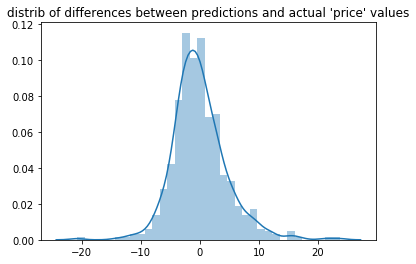

In [69]:
# Your code here
yhat = model3.predict(X[selected_col])
print(type(yhat),yhat.shape)
print(type(y), y.shape)
y2=y.values
print(type(y2), y2.shape)
diff = pd.DataFrame(y2-yhat)
print(diff.describe())
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(diff)
plt.title("distrib of differences between predictions and actual 'price' values" )
plt.show();


Now, using the formulas of R-squared and adjusted R-squared below, and your Python/numpy knowledge, compute them and contrast them with the R-squared and adjusted R-squared in your statsmodels output using stepwise selection. Which of the two models would you prefer?

$SS_{residual} = \sum (y - \hat{y})^2 $

$SS_{total} = \sum (y - \bar{y})^2 $

$R^2 = 1- \dfrac{SS_{residual}}{SS_{total}}$

$R^2_{adj}= 1-(1-R^2)\dfrac{n-1}{n-p-1}$

In [76]:
# Your code here
SS_res = np.sum( (y - yhat)**2  )
SS_total = np.sum( (y - np.mean(y))**2)
Rsq = 1-SS_res/SS_total
print(Rsq)
print(X[selected_col].shape[1])
Rsqadj =1- (1-Rsq)*(len(y) - 1)/ (len(y) - X[selected_col].shape[1] - 1)
Rsqadj
# r_squared is 0.742981  
# adjusted_r_squared is 0.740411

price    0.742981
dtype: float64
5


price    0.740411
dtype: float64

## Level up (Optional)

- Perform variable selection using forward selection, using this resource: https://planspace.org/20150423-forward_selection_with_statsmodels/. Note that this time features are added based on the adjusted R-squared!
- Tweak the code in the `stepwise_selection()` function written above to just perform forward selection based on the p-value 

## Summary
Great! You practiced your feature selection skills by applying stepwise selection and recursive feature elimination to the Boston Housing dataset! 

In [70]:
# Would we find the same best predictors as with stasmodel forward-backward feature selection using p-values
# if we had asked 7 to scikit-learn RFE?
selector2= RFE(linreg, n_features_to_select = 7)  # RFE = Recursive Feature Elimination
selector2 = selector2.fit(X,y.values.ravel()) # convert y to 1d np array to prevent DataConversionWarning
selector2.support_

array([False, False,  True,  True, False,  True,  True,  True,  True,
       False, False,  True])

In [71]:
print(X.columns)
print(results)
selected_col2= X.columns[selector2.support_]
selected_col2

Index(['CRIM', 'INDUS', 'CHAS', 'RM', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT',
       'RAD_(6, 24]', 'TAX_(270, 360]', 'TAX_(360, 712]'],
      dtype='object')
['LSTAT', 'RM', 'PTRATIO', 'DIS', 'B', 'INDUS', 'CHAS']


Index(['CHAS', 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT', 'TAX_(360, 712]'], dtype='object')

In [ ]:
# Would we find the same best predictors as with stasmodel forward-backward feature selection using p-values
# if we had asked 7 to scikit-learn RFE? 
# NO! :( 
#?????